# Eight Schools Analysis
This notebook reproduces the eight schools analysis from Section 6 of "Hierarchical Causal Models", E. N. Weinstein and D. M. Blei, 2023.

To run the notebook, make sure you are using Python 3 and have the below packages installed in your environment. The code was tested with

-- python=3.12.0

-- numpy=1.26.2

-- numpyro=0.13.2

-- jax=0.4.23

-- matplotlib=3.8.0


In [14]:
import numpy as np
from copy import deepcopy

import jax.numpy as jnp
from jax.scipy.special import expit
from jax.nn import softplus
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam
from numpyro.infer import Predictive
from numpyro.handlers import block

import matplotlib.pyplot as plt

# Whether and where to save figures.
save_figs = False
save_folder = 'saved_figs/'

# Data
Data from Alderman & Powers (1979)

In [15]:
# Number of schools.
N = 8
# Estimated treatment effects (with covariates).
y_diff_mn = np.array([28,  8, -3,  7, -1,  1, 18, 12])
# Standard error of effect estimates.
y_diff_se = np.array([15, 10, 16, 11, 9, 11, 10, 18])
# Size of treatment group.
a1_m = np.array([28, 39, 22, 48, 25, 37, 24, 16])
# Size of control group.
a0_m = np.array([22, 40, 17, 43, 74, 35, 70, 19])
# Class size.
c = np.array([1, 20, 10, 24, 30, 6, 12, 10])
# Total enrollment in experiment.
s = a1_m + a0_m  # -> array([50, 79, 39, 91, 99, 72, 94, 35])
# Fraction of students treated.
qa = a1_m / s
# Outcome (SAT-V) school average.
y_mn = np.array([468.60, 418.73, 431.03, 407.36, 494.44, 422.50, 549.57, 401.14])
# Outcome standard deviation.
y_sd = np.array([108.0, 96.6, 81.9, 94.7, 99.4, 89.3, 72.9, 81.0])
# Outcome standard error.
y_se = y_sd / np.sqrt(s)

Summary plots

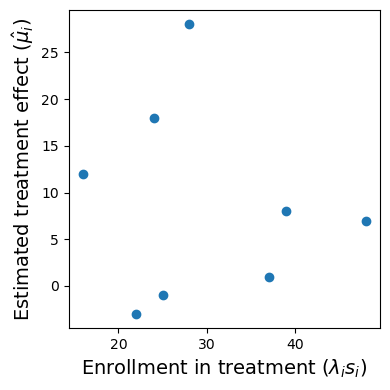

In [16]:
plt.figure(figsize=(4, 4))
plt.scatter(a1_m, y_diff_mn)
plt.xlabel(r'Enrollment in treatment ($\lambda_i s_i$)', fontsize=14)
plt.ylabel(r'Estimated treatment effect ($\hat{\mu}_i$)', fontsize=14)
plt.tight_layout()
if save_figs:
    plt.savefig(save_folder + 'enrollment_v_effect.pdf')

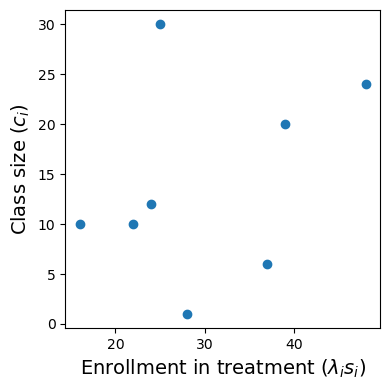

In [17]:
plt.figure(figsize=(4, 4))
plt.scatter(a1_m, c)
plt.xlabel(r'Enrollment in treatment ($\lambda_i s_i$)', fontsize=14)
plt.ylabel(r'Class size ($c_i$)', fontsize=14)
plt.tight_layout()
if save_figs:
    plt.savefig(save_folder + 'enrollment_v_class.pdf')

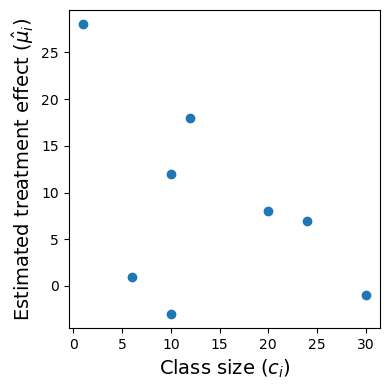

In [18]:
plt.figure(figsize=(4, 4))
plt.scatter(c, y_diff_mn)
plt.xlabel(r'Class size ($c_i$)', fontsize=14)
plt.ylabel(r'Estimated treatment effect ($\hat{\mu}_i$)', fontsize=14)
plt.tight_layout()
if save_figs:
    plt.savefig(save_folder + 'class_v_effect.pdf')

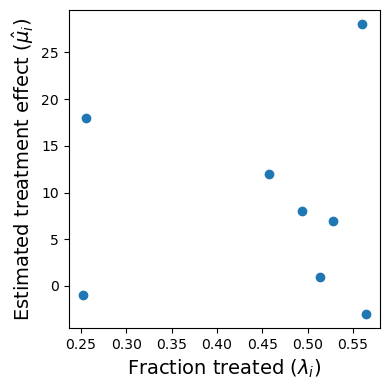

In [19]:
plt.figure(figsize=(4, 4))
plt.scatter(qa, y_diff_mn)
plt.xlabel(r'Fraction treated ($\lambda_i$)', fontsize=14)
plt.ylabel(r'Estimated treatment effect ($\hat{\mu}_i$)', fontsize=14)
plt.tight_layout()
if save_figs:
    plt.savefig(save_folder + 'frac_treated_v_effect.pdf')

# Model 1 & 2: fully observed & hidden unit confounder

In [7]:
# This model is equivalent to the classic eight schools hierarchical Bayesian analysis.
# This implementation follows that in the NumPyro tutorial, https://github.com/pyro-ppl/numpyro.
def classic_eight_schools(N, se, y=None):
    # Sample parameters describing p(q^{y|a}).
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    nu = numpyro.sample('nu', dist.Normal(0, 5))
    with numpyro.plate('N', N):
        with numpyro.handlers.reparam(config={'mu': TransformReparam()}):
            # Sample mu, which parameterizes q^{y|a}_i
            mu = numpyro.sample(
                        'mu',
                        dist.TransformedDistribution(dist.Normal(0., 1.),
                                                     dist.transforms.AffineTransform(nu, tau)))
            # Sample observed data, with observed standard errors.
            numpyro.sample('obs', dist.Normal(mu, se), obs=y)

# Run MCMC to sample from the posterior.
nuts_kernel = NUTS(classic_eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, N, y_diff_se, y=y_diff_mn, extra_fields=('potential_energy',))
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [00:01<00:00, 5518.25it/s, 7 steps of size 5.06e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      6.12      5.58      5.59     -2.80     14.56  10029.34      1.00
     mu[1]      4.91      4.71      4.78     -2.74     12.67  11747.98      1.00
     mu[2]      3.91      5.22      4.16     -4.43     12.10   9829.40      1.00
     mu[3]      4.73      4.73      4.69     -2.72     12.62  12184.50      1.00
     mu[4]      3.53      4.63      3.78     -3.80     10.97   9965.84      1.00
     mu[5]      4.00      4.92      4.15     -3.64     12.00  11070.74      1.00
     mu[6]      6.34      5.24      5.78     -2.13     14.29   9683.14      1.00
     mu[7]      4.85      5.33      4.70     -3.38     13.23  10334.42      1.00
mu_base[0]      0.32      0.99      0.32     -1.33      1.92  12745.38      1.00
mu_base[1]      0.09      0.94      0.09     -1.50      1.59  14537.66      1.00
mu_base[2]     -0.09      0.97     -0.10     -1.69      1.50  13201.56      1.00
mu_base[3]      0.06      0

In [8]:
# Extract samples of the ATE from the posterior samples.
# In this case, nu directly parameterizes the ATE.
ATE_classic = mcmc.get_samples()['nu']

In [9]:
print('Posterior mean of ATE', np.mean(ATE_classic))
print('Posterior mean standard error (from numerical uncertainty)', np.std(ATE_classic)/np.sqrt(len(ATE_classic)))
print('Posterior standard deviation', np.std(ATE_classic))
print('Posterior 0.05 quantile', np.quantile(ATE_classic, 0.05))
print('Posterior 0.95 quantile', np.quantile(ATE_classic, 0.95))

Posterior mean of ATE 4.375994
Posterior mean standard error (from numerical uncertainty) 0.033782374
Posterior standard deviation 3.3782372
Posterior 0.05 quantile -1.1807920277118682
Posterior 0.95 quantile 9.814584112167356


## Model 3: Hidden unit confounder and interference

In [10]:
def interfere_eight_schools(N, se, S=None, QA=None, C=None, y_diff=None):
    # Sample parameters describing p(q^a)
    mnQA = numpyro.sample('mnQA', dist.Normal(0., 10.))
    concQA = numpyro.sample('concQA', dist.Normal(0., 10.))
    # Parameters describing p(s).
    mnS = numpyro.sample('mnS', dist.Normal(50, 100))
    scaleS = numpyro.sample('scaleS', dist.HalfCauchy(100))
    
    # Sample parameters describing p(c | q^a, s)
    alphaC = numpyro.sample('alphaC', dist.Normal(0, 50))
    deltaC = numpyro.sample('deltaC', dist.Normal(10, 100))
    sigmaC = numpyro.sample('sigmaC', dist.HalfCauchy(10))
    
    # Sample parameters describing p(q^{y|a} | q^a, s, c)
    alphaY = numpyro.sample('alphaY', dist.Normal(0, 100))
    betaY = numpyro.sample('betaY', dist.Normal(0, 100))
    deltaY = numpyro.sample('deltaY', dist.Normal(0, 500))
    tau_diff = numpyro.sample('tau_diff', dist.HalfCauchy(5))
    
    with numpyro.plate('N', N):
        with numpyro.handlers.reparam(config={'mu': TransformReparam()}):
            # Parameter describing the mean of q^a_i.
            qa = numpyro.sample('QA', dist.BetaProportion(expit(mnQA), softplus(concQA)), 
                                obs=QA)
            # Sample S_i.
            s = numpyro.sample('S', dist.Normal(mnS, scaleS), obs=S)

            # Sample C_i.
            # Note: we clip the value of S, the total number of students, to be greater than one.
            # Note this only affects predictions, not inference.
            c = numpyro.sample('C', dist.Normal(alphaC * qa * np.clip(s, 1, None) + deltaC, 
                                                sigmaC), obs=C)
            
            def mechanismY(ialphaY, iC, iS, ibetaY, iQA, ideltaY):
                # Note: we clip the value of C, the class size, to be greater than one and
                # no more than the total number of students S.
                # Note this only affects predictions, not inference.
                return (ialphaY * np.clip(iC, 1, np.clip(iS, 1, None)) + 
                        ibetaY * iQA * np.clip(iS, 1, None) + 
                        ideltaY)
            
            # Compute and store nu, the (conditional) mean of the distribution over nu.
            nu = numpyro.sample('nu', dist.Delta(mechanismY(alphaY, c, s, betaY, qa, deltaY)))

            # Sample mu, which parameterizes q^{y|a}_i.
            mu = numpyro.sample(
                        'mu',
                        dist.TransformedDistribution(
                            dist.Normal(0., 1.),
                            dist.transforms.AffineTransform(
                                nu, tau_diff)))

            # Sample observed data, with observed standard errors.
            obs_diff = numpyro.sample('obs', dist.Normal(mu, se), obs=y_diff)

# Run MCMC to sample from the posterior.
nuts_kernel = NUTS(block(interfere_eight_schools, hide=['nu']))
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, N, y_diff_se, S=s, QA=qa, C=c, y_diff=y_diff_mn, 
         extra_fields=('potential_energy',))
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [00:03<00:00, 2923.95it/s, 31 steps of size 1.43e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alphaC      0.29      0.42      0.29     -0.41      0.94   6086.20      1.00
    alphaY     -0.48      0.50     -0.48     -1.25      0.36  11801.82      1.00
     betaY     -0.03      0.49     -0.03     -0.78      0.79   7942.42      1.00
    concQA     12.16      4.80     11.62      4.49     19.77  10426.44      1.00
    deltaC      5.64     13.33      5.49    -15.35     27.25   6165.92      1.00
    deltaY     16.53     16.57     16.55     -9.91     44.27   8016.90      1.00
      mnQA     -0.20      0.21     -0.20     -0.54      0.14  12043.76      1.00
       mnS     69.88     11.11     69.85     52.75     87.99   9668.70      1.00
     mu[0]     16.41      9.15     16.14      1.42     31.07  12275.88      1.00
     mu[1]      6.26      6.24      6.22     -4.19     16.02  10387.65      1.00
     mu[2]     10.00      7.90     10.34     -2.65     22.59  10503.29      1.00
     mu[3]      4.15      8

In [11]:
# Get distribution over C after hard intervention setting A = 1.
# (This corresponds to the first term of the identification formula.)
predict_Cdo1 = Predictive(interfere_eight_schools, mcmc.get_samples(), return_sites=['C'])
samples_Cdo1 = predict_Cdo1(random.PRNGKey(1), 1, 0., QA=1.)

# Get distribution over expected test scores (mu) under intervened C distribution.
# (This corresponds to the full identification formula.)
mcmc_samples = deepcopy(mcmc.get_samples())
mcmc_samples['C'] = random.permutation(random.PRNGKey(3), samples_Cdo1['C'].squeeze())
mcmc_samples.pop('mu')
predict_mudoC = Predictive(interfere_eight_schools, mcmc_samples, 
                              return_sites=['nu', 'S', 'C', 'QA'])
sample_mudoC = predict_mudoC(random.PRNGKey(4), 1, 0.)
ATE = sample_mudoC['nu'].squeeze()

In [12]:
print('Posterior mean of ATE', np.mean(ATE))
print('Posterior mean standard error (from numerical uncertainty)', np.std(ATE)/np.sqrt(len(ATE)))
print('Posterior standard deviation', np.std(ATE))
print('Posterior 0.05 quantile', np.quantile(ATE, 0.05))
print('Posterior 0.95 quantile', np.quantile(ATE, 0.95))

Posterior mean of ATE 4.197117
Posterior mean standard error (from numerical uncertainty) 0.17366476
Posterior standard deviation 17.366476
Posterior 0.05 quantile -26.138375282287598
Posterior 0.95 quantile 27.861116886138884


### Plot results

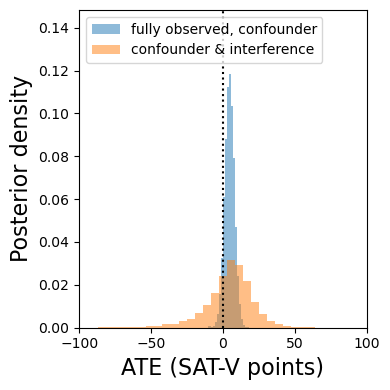

In [13]:
plt.figure(figsize=(4, 4))
hist_n_2, _, _ = plt.hist(ATE_classic, bins=20, density=True, alpha=0.5, label='fully observed, confounder')
hist_n, _, _ = plt.hist(ATE, bins=50, density=True, alpha=0.5, label='confounder & interference')
up_limit = np.maximum(np.max(hist_n), np.max(hist_n_2)) * 1.25
plt.plot([0, 0], [0, up_limit], 'k:')
plt.ylim([0, up_limit])
plt.xlim([-100, 100])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('ATE (SAT-V points)', fontsize=16)
plt.ylabel('Posterior density', fontsize=16);
plt.tight_layout()
if save_figs:
    plt.savefig(save_folder + 'schools_ATE_posteriors.pdf');